# CLASE 4.4: INTERPOLACIÓN
---
## Introducción.
En el campo del análisis numérico se denomina **interpolación** a cualquier método que, dado un conjunto discreto de puntos, nos permita determinar puntos intermedios a los existentes. En el caso partícular de los problemas típicos de ciencia e ingeniería, con frecuencia disponemos de un conjunto de datos obtenidos mediante algún proceso físico de muestreo o experimentación. Por ejemplo, muestras de concentrado tomadas cada turno en un circuito de flotación que nos permiten medir, con una precisión instrumental, cantidades importantes para el proceso completo, tales como la ley de concentrado, humedad y granulometría. 

Podemos asumir que tales cantidades representan los valores de una función para un número limitado de valores de un cierto conjunto de variables independientes. Con frecuencia, suele requerirse que interpolemos tales valores, a fin de encontrar cantidades intermedias que permitan mejorar la granularidad de la data de interés. Por ejemplo, si muestreamos leyes de concentrado turno a turno, quizás querramos interpolar dicha data para disponer de valores cada 4 horas (suponiendo que los turnos duran 12 horas). Cualquiera sea el caso, la interpolación suele implicar la resolución del problema complementario: Determinar una función que pase por los puntos muestreados y que tenga una geometría *aproximadamente similar* a la función que genera tales puntos, que en general será desconocida. Tales condiciones geométricas implican restricciones que normalmente se aplican no sólo a los valores de la función a interpolar, sino que también a sus derivadas.

Antes de entrar en detalles relativos a la implementación de una interpolación en Python, primero abordaremos el contexto matemático que nos permite formular este problema de manera consistente. En esta sección, consideraremos primeramente los problemas de tipo unidimensional, y que pueden formularse como sigue: Dado un conjunto con $m$ observaciones del tipo $\left\{ \left( x_{i},y_{i}\right)  \right\}^{m}_{i=1}$, estamos interesados en encontrar una función $f$ tal que $y_{i}=f(x_{i})$, para $1\leq i\leq m$. La función $f$ suele denominarse como **interpolador**, y no es única. De hecho, se desprende, de la descripción del problema, que existen infinitos interpoladores para un conjunto discreto de datos. En general, solemos escribir la función interpoladora $f$ como una combinación lineal de $n$ funciones base, denotadas como $\phi_{j}$, tales que $f\left( x\right)  =\sum\nolimits^{n}_{j=1} c_{j}\phi_{j} \left( x\right)$, donde los $c_{j}$ son números reales que deseamos determinar, llamados **coeficientes de la interpolación**.

Al sustituir los puntos $\left\{ \left( x_{i},y_{i}\right)  \right\}^{m}_{i=1}$ en la combinación lineal anterior, el resultado es un sistema lineal de $m$ ecuaciones con $n$ incógnitas. Por supuesto, idealmente nos interesamos en el caso $m=n$, a fin de asegurar una solución única para dicho sistema. Tal sistema puede escribirse matricialmente como

$$\underbrace{\left( \begin{array}{cccc}\phi_{1} \left( x_{1}\right)  &\phi_{2} \left( x_{1}\right)  &\cdots &\phi_{n} \left( x_{1}\right)  \\ \phi_{1} \left( x_{2}\right)  &\phi_{2} \left( x_{2}\right)  &\cdots &\phi_{n} \left( x_{2}\right)  \\ \vdots &\vdots &\ddots &\vdots \\ \phi_{1} \left( x_{n}\right)  &\phi_{2} \left( x_{n}\right)  &\cdots &\phi_{n} \left( x_{n}\right)  \end{array} \right)  }_{\mathbf{\Phi(\mathbf{x}) } } \underbrace{\left( \begin{array}{c}c_{1}\\ c_{2}\\ \vdots \\ c_{n}\end{array} \right)  }_{\mathbf{c} } =\underbrace{\left( \begin{array}{c}y_{1}\\ y_{2}\\ \vdots \\ y_{n}\end{array} \right)  }_{\mathbf{y} }$$
</p> <p style="text-align: right;">$(4.1)$</p>

Vemos pues que el sistema anterior puede escribirse en forma compacta como $\mathbf{\Phi } \left( \mathbf{x} \right)  \mathbf{c} =\mathbf{y}$. En esta formulación, con $m=n$, se tiene que el número de funciones base es el mismo que el número de puntos observados para construir la interpolación y, por extensión, $\mathbf{\Phi } \left( \mathbf{x} \right)$ es una matriz cuadrada de orden $n$.

La elección de las funciones base afecta, por supuesto, a las propiedades del sistema (4.1), y una elección adecuada dependerá de las propiedades de la data que queremos interpolar. Algunos tipos frecuentes de funciones base incluyen funciones potenciales del tipo $\phi_{j}(x)=x^{j-1}$, polinomios ortogonales, o polinomios definidos entre cada par de puntos (llamados **splines**). Notemos que, si bien no existe una única función interpoladora, sí existe un único polinomio de interpolación y que es independiente de las funciones base escogidas. Esto lo veremos en detalle un poco más adelante.

En esta sección, haremos uso de **Scipy** para construir interpolaciones de forma eficiente. En particular, haremos uso del módulo `scipy.interpolate`, el cual se especializa en este tipo de problemas. Nos apoyaremos igualmente con el módulo de álgebra lineal de **Scipy**, llamado `scipy.linalg`, y el módulo especializado en polinomios de **Numpy**, llamado `numpy.polynomial`:

In [1]:
# Importación de librerías.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy

In [2]:
# Importación de módulos.
from numpy import polynomial as P
from scipy import interpolate
from scipy import linalg

In [3]:
# Setting de parámetros de graficación.
sns.set()
plt.rcParams["figure.dpi"] = 100 # Resolución de nuestras figuras.
plt.style.use("seaborn-v0_8-white") # Template de estilo.

In [4]:
# Inicializamos la impresión resultados simbólicos de Sympy.
sympy.init_printing()

In [5]:
%matplotlib notebook

## Interpolación polinomial.
La **interpolación polinomial** es el caso particular cuando las funciones base del sistema (4.1) se construyen a partir de la base canónica del conjunto de todos los polinomios de orden $n-1$ (que solemnos denominar como $\mathbb{R}_{n-1}[x]$), y que se escribe como $\alpha=\left\{ 1,x,...,x^{n-1}\right\}$. Luego, estamos interesados en determinar el polinomio $P_{n-1}\in \mathbb{R}_{n-1}[x]$ que interpola a una función arbitraria $f$ en los puntos $(x_{i},y_{i})_{i=1}^{n}$. De esta manera, $P_{n-1}(x_{i})=y_{i}$ para $i=1,...,n$, con lo cual el sistema (4.1) toma la forma

$$\left( \begin{array}{ccccc}1&x_{1}&x^{2}_{1}&\cdots &x^{n-1}_{1}\\ 1&x_{2}&x^{2}_{2}&\cdots &x^{n-1}_{2}\\ 1&x_{3}&x^{2}_{3}&\cdots &x^{n-1}_{3}\\ \vdots &\vdots &\vdots &\ddots &\vdots \\ 1&x_{n}&x^{2}_{n}&\cdots &x^{n-1}_{n}\end{array} \right)  \left( \begin{array}{c}c_{1}\\ c_{2}\\ c_{3}\\ \vdots \\ c_{n}\end{array} \right)  =\left( \begin{array}{c}y_{1}\\ y_{2}\\ y_{3}\\ \vdots \\ y_{n}\end{array} \right)$$
</p> <p style="text-align: right;">$(4.2)$</p>

Este sistema puede escribirse de manera compacta como $\mathbf{V} \mathbf{c} =\mathbf{y}$, donde $\mathbf{V}$ es una matriz de Vandermonde; es decir, una matriz tal que cada una de sus filas constituyen una progresión geométrica. Es posible demostrar que una matriz de Vandermonde es no singular (es decir, invertible y con determinante no nulo, $\det \left( \mathbf{V} \right)  =\prod\nolimits^{n}_{j=1;i>j} \left( x_{i}-x_{j}\right)$) siempre que las progresiones geométricas en cada fila estén definidas en función de variables diferentes, que es el caso para la matriz $\mathbf{V}$. Por lo tanto, el sistema (4.2) tiene solución única y, por extensión, existe un único polinomio de grado $n-1$ que interpola a la función $f$ en los puntos $(x_{i},y_{i})_{i=1}^{n}$.

**Ejemplo 4.1:** En la siguiente tabla se especifican los valores que toma una función $f$ desconocida en un conjunto dado de valores de $x$:

| Valor de $x_{i}$ | Valor de $y_{i}$ |
| :--------------: | :--------------: |
| -1               | -1               |
| 2                | -4               |
| 4                | 4                |

Vamos a utilizar la igualdad (4.2) para encontrar el polinomio $P$ de menor grado que interpola estos puntos. Es evidente que $P$ es un polinomio de grado 4, ya que tenemos 5 puntos en total para ejecutar la interpolación. De esta manera, podemos escribir $P$ como $P\left( x\right)  =\sum\nolimits^{2}_{i=0} c_{i}x^{i}$, siendo tal que $P(-1)=-1, P(2)=-4$ y $P(4)=4$. De esta manera, llegamos al sistema

$$\left( \begin{array}{rrr}1&-1&1\\ 1&2&4\\ 1&4&16\end{array} \right)  \left( \begin{array}{r}c_{0}\\ c_{1}\\ c_{2}\end{array} \right)  =\left( \begin{array}{r}-1\\ -4\\ 4\end{array} \right)$$
</p> <p style="text-align: right;">$(4.3)$</p>

Este sistema puede resolverse fácilmente haciendo uso de **Sympy**:

In [6]:
# Definimos las incógnitas del sistema.
c0, c1, c2 = sympy.symbols("c_{0}, c_{1}, c_{2}", real=True)
c = sympy.Matrix([c0, c1, c2])

In [7]:
# Definimos la matriz de Vandermonde con los coeficientes del sistema.
V = sympy.Matrix([
    [1, -1, 1],
    [1, 2, 4],
    [1, 4, 16],
])

In [8]:
# Definimos la matriz resultante del sistema.
y = sympy.Matrix([-1, -4, 4])

In [9]:
# Resolvemos el sistema mediante una factorización LU.
result = V.LUsolve(y)

In [10]:
# Mostramos el resultado en pantalla.
result.T

[-4  -2  1]

Por lo tanto, el polinomio interpolador está dado por $P(x)=-4-2x+x^{2}$. ◼

En general, no es recomendable determinar polinomios de interpolación mediante el uso del método basado en las matrices de Vandermonde. La razón de aquello estriba en que los sistemas matriciales del tipo (4.2) suelen estar mal condicionados, lo que implica que pequeñas variaciones en los elementos de la matriz $\mathbf{V}$ pueden producir enormes diferencias en las soluciones resultantes del sistema $\mathbf{V} \mathbf{c} =\mathbf{y}$, siendo así propensas a grandes errores de redondeo. Por esta razón es que existen otros enfoques que permiten obtener de manera mucho más efectiva los polinomios de interpolación (por ejemplo, los métodos de Lagrange y de interpolación por diferencias divididas).

### Creación de polinomios en Python.
La librería **Numpy** nos provee del módulo `numpy.polynomial` (que suele importarse mediante el alias `P`), y que nos permite utilizar una serie de funciones y clases especializadas en el trabajo con polinomios. En particular, nos permite trabajar con familias especiales de polinomios denominadas **ortogonales** con respecto a una función de peso. Formalmente, dos polinomios $P_{m}(x)$ y $P_{n}(x)$ son ortogonales con respecto a una función de peso $w:\left[ a,b\right]  \rightarrow \mathbb{R}$ si se cumple que

$$\left< P_{m}\left( x\right)  ,P_{n}\left( x\right)  \right>  =\int^{b}_{a} P_{m}\left( x\right)  P_{n}\left( x\right)  w\left( x\right)  dx=0$$
</p> <p style="text-align: right;">$(4.4)$</p>

Los polinomios ortogonales son importantes en el análisis numérico y la interpolación. Por lo tanto, previo a entrar de lleno a la implementación de interpolaciones polinomiales por medio de **Scipy**, haremos un pequeño tour por el módulo `numpy.polynomial`. Dicho módulo cuenta con funciones y clases para representar polinomios en diferentes bases. La base canónica de $\mathbb{R}_{n}[x]$, como comentamos previamente, es $\alpha=\left\{ 1,x,x^{2},...,x^{n}\right\}$, y es posible construir polinomios sobre dicha base en `numpy.polynomials` usando la clase `Polynomial`. Por ejemplo, podemos construir el polinomio $P\left( x\right)  =2-x+5x^{2}-4x^{3}$ imputando los coeficientes en el orden de la base canónica, en el formato de una lista de Python, como sigue:

In [11]:
# Construimos nuestro polinomio (sobre la base canónica).
P1 = P.Polynomial([2, -1, 5, -4])

Si tenemos activa la impresión de variables simbólicas de **Sympy**, al mostrar este polinomio en pantalla, veremos su expresión simbólica completa:

In [12]:
# Mostramos nuestro polinomio en pantalla.
P1

Polynomial([ 2., -1.,  5., -4.], domain=[-1,  1], window=[-1,  1])

Pero si no tenemos activa dicha opción, lo que veremos será lo siguiente:

Alternativamente, también es posible crear un polinomio a partir de sus raíces. Es decir, a partir de los puntos $x_{i}$ tales que $P_{n-1}(x_{i})=0$ (donde $0\leq i\leq n-1$). Para ello, podemos usar el método `fromroots()` a partir de la clase `Polynomial`, la cual creará un polinomio $P_{n-1}(x)$ con raíces $x_{i}$ a partir de la expresión $P_{n-1}(x)=\left( x-x_{0}\right)  \left( x-x_{1}\right)  \cdots \left( x-x_{n-1}\right)  =\prod\nolimits^{n-1}_{i=0} \left( x-x_{i}\right)$. Por ejemplo:

In [13]:
# Creamos un polinomio a partir de las raíces x=-1 y x=1.
P2 = P.Polynomial.fromroots([-1, 1])

In [14]:
# Mostramos nuestro polinomio en pantalla.
P2

Polynomial([-1.,  0.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

Vemos pues que el polinomio creado es $P\left( x\right)  =\left( x-1\right)  \left( x+1\right)  =x^{2}-1$.

Por otro lado, para cualquier polinomio creado en `numpy.polynomial`, podemos calcular las correspondientes raíces, usando el método `roots()`, sobre la instancia de la clase `Polynomial`:

In [15]:
# Calculamos las raíces del polinomio P1.
P1.roots()

array([-0.04574119-0.60879368j, -0.04574119+0.60879368j,
        1.34148238+0.j        ])

In [16]:
# Calculamos las raíces del polinomio P2.
P2.roots()

array([-1.,  1.])

Cada instancia de la clase `Polynomial` contiene tres listas que lo caracterizan. La primera contiene los coeficientes del polinomio respectivo, y que solemos imputar a su constructor. Las otras dos listas son `domain` y `window`, y que representan el dominio y recorrido del polinomio en términos de la correspondiente transformación lineal entre `domain[i]` y `window[i]`, a modo de factores de escalamiento y traslación (es decir, del tipo $T(v)=\lambda v$, con $\lambda \in \mathbb{R}$). Los valores por defecto son `domain=[-1, 1]` y `window=[-1, 1]`, los que implican que no se aplica ningún factor de escalamiento. Estos atributos resultan particularmente útiles cuando trabajamos con polinomios ortogonales con respecto a alguna función de peso sobre un intervalo específico (como en la Ec. (4.4)). Podemos acceder a todas estas propiedades mediante los atributos `coef`, `domain` y `window`, respectivamente:

In [17]:
# Coeficientes del polinomio P1.
P1.coef

array([ 2., -1.,  5., -4.])

In [18]:
# Dominio del polinomio P1.
P1.domain

array([-1,  1])

In [19]:
# Ventana o recorrido del polinomio P1.
P1.window

array([-1,  1])

Cualquier polinomio creado como una instancia de la clase `Polynomial` puede ser fácilmente evaluado sobre valores arbitrarios de $x$, usando dicha instancia como una función cuyo argumento será un arreglo unidimensional con los valores de $x$ que sean de interés. Por ejemplo, si queremos evaluar el polinomio `P1` en un intervalo de valores comprendido en el rango $[-1, 1]$, bastará con escribir:

In [20]:
# Evaluación de P1 en el rango [-1, 1].
x = np.linspace(start=-1, stop=1, num=100)
y = P1(x)

<IPython.core.display.Javascript object>


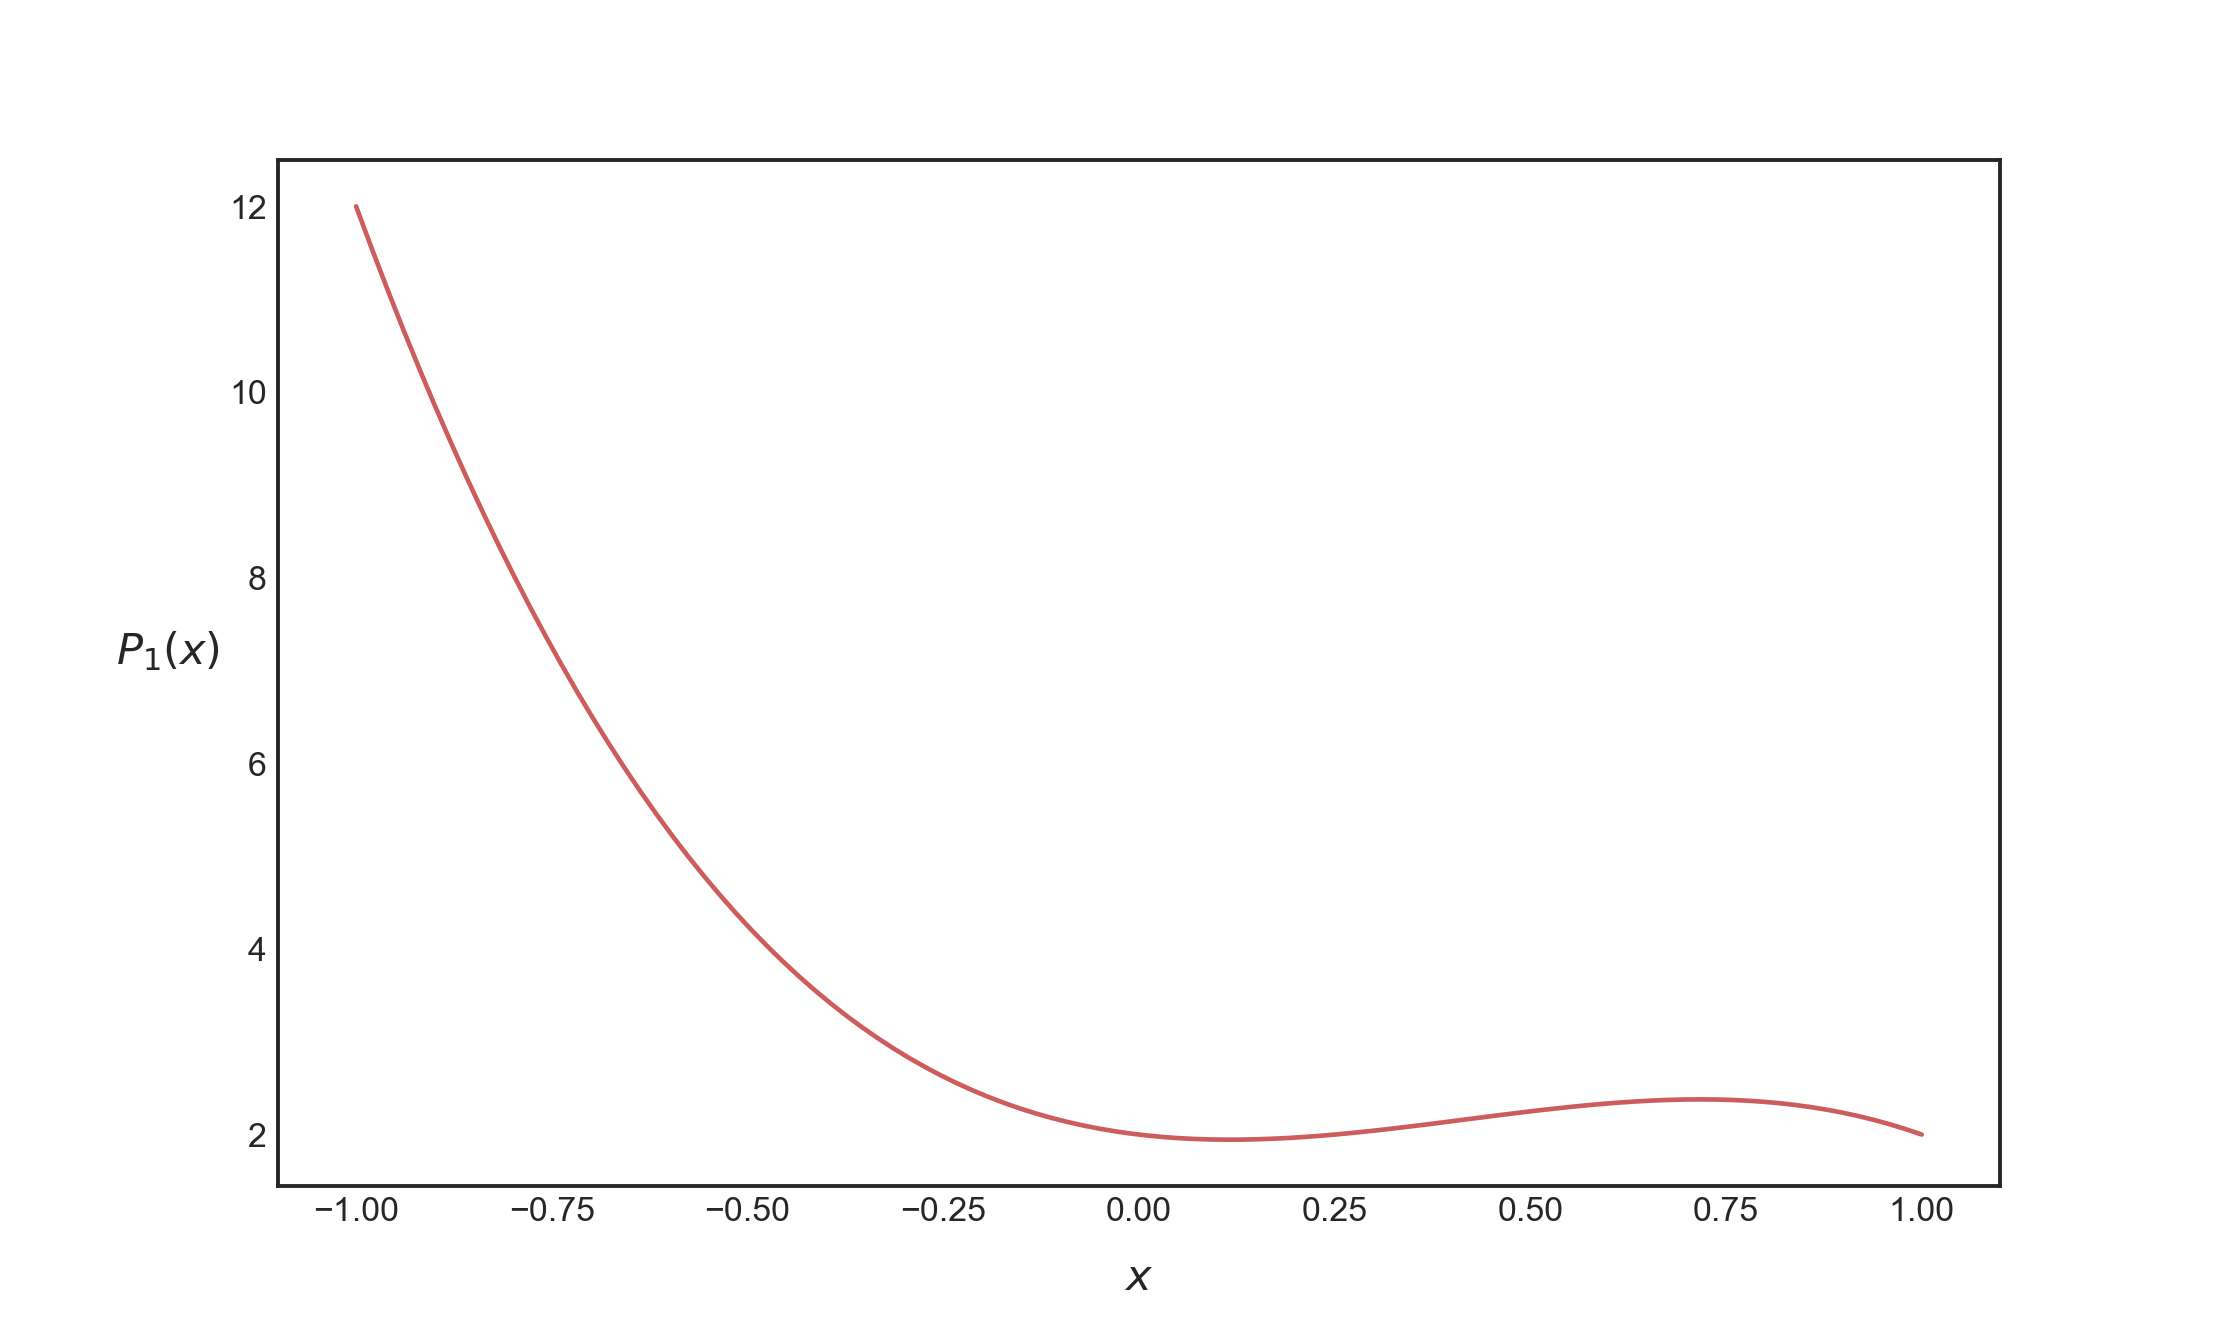

In [21]:
# Graficamos nuestro polinomio.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color="indianred")
ax.set_xlabel(r"$x$", fontsize=14, labelpad=10)
ax.set_ylabel(r"$P_{1}(x)$", fontsize=14, labelpad=20, rotation=0);

Las instancias de la clasde `Polynomial` puede, además, ser operadas aritméticamente de manera clásica, de la misma forma en que lo haríamos con arreglos de **Numpy**. La única diferencia es que el operador `//`, que es usado para la división entera entre elementos de un arreglo, al aplicarla sobre polinomios, se convertirá literalmente en una división algebraica de polinomios. Para comprobar esto, calcularemos la división entre los polinomios $P(x)$ y $Q(x)$, definidos como $Q(x)=(x-4)(x+5)(x-2)$ y $R(x)=x+5$. Al expresar los polinomios de esta manera, es evidente que el resultado de la división entre $Q$ y $R$ será $Q(x)/R(x)=(x-4)(x-2)=x^{2}-6x+8$. Comprobémoslo:

In [22]:
# Construimos los polinomios P y Q.
Q = P.Polynomial.fromroots([-5, 2, 4])
R = P.Polynomial.fromroots([-5])

In [23]:
# Realizamos la división entre Q y R.
Q // R

Polynomial([ 8., -6.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

Lo que, efectivamente, comprueba nuestro cálculo.